<a href="https://colab.research.google.com/github/meka-soluciones/Inteligencia-Artificial/blob/main/Code%20Adquisicion_Se%C3%B1al_PPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Se lee directamente del archivo usb ##

Señal cruda del Sensor

Saving ppg_simulada_con_anomalia.csv to ppg_simulada_con_anomalia (4).csv


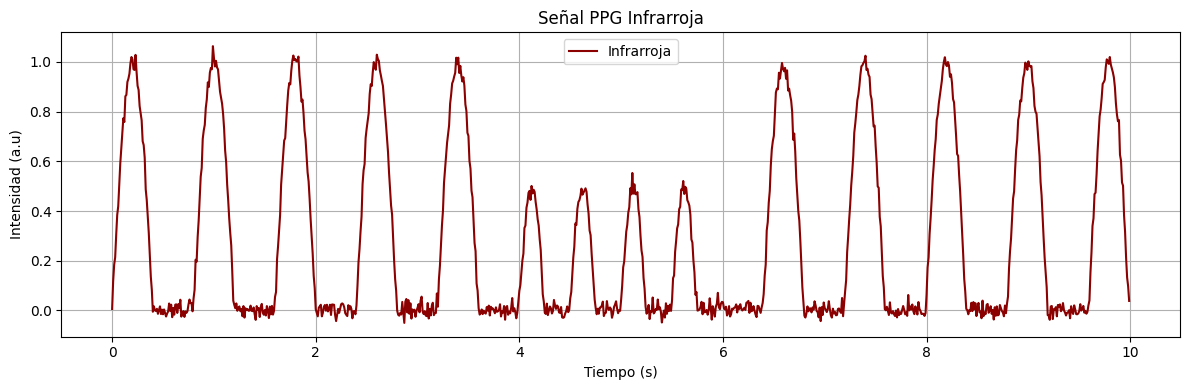

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

df["ppg_ir"] = df["ppg_ir"].values

#frecuencia de muestreo
fs = 100

df["time"] = np.arange(len(df)) / fs

plt.figure(figsize=(12, 4))
plt.plot(df["time"], df["ppg_ir"], label="Infrarroja", color='darkred')
plt.title("Señal PPG Infrarroja")
plt.xlabel("Tiempo (s)")
plt.ylabel("Intensidad (a.u)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Se añade una etapa de Filtrado pasa bandas entre 0.5 y 5 Hz Para eliminar frecuencias cardiacas humanas no relacionadas con el pulso.

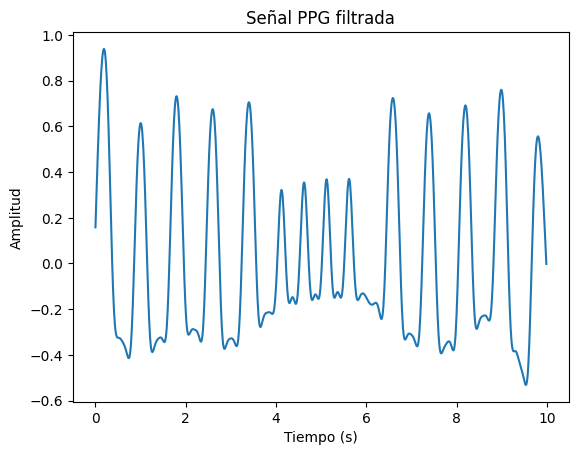

In [ ]:
from scipy.signal import butter, filtfilt, find_peaks
def bandpass_filter(signal, fs=100, low=0.5, high=5):
    nyq = 0.5 * fs
    b, a = butter(4, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, signal)

filtered = bandpass_filter(df["ppg_ir"].values, fs)

plt.plot(df["time"], filtered)
plt.title("Señal PPG filtrada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.show()

Deteccion de los Picos, Latidos de la señal filtrada. Se considera 0.6segundos entre picos (100BPM) maximos

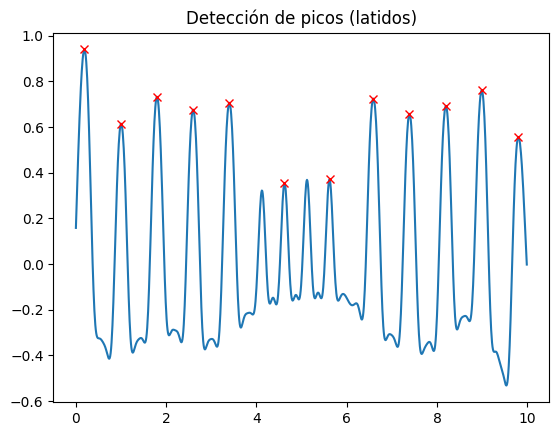

Frecuencia cardíaca estimada: 72.07 BPM


In [ ]:
peaks, _ = find_peaks(filtered, distance=fs*0.6)

plt.plot(df["time"], filtered)
plt.plot(df["time"].iloc[peaks], filtered[peaks], "rx")
plt.title("Detección de picos (latidos)")
plt.show()

bpm = 60 * len(peaks) / (df["time"].iloc[-1] - df["time"].iloc[0])
print(f"Frecuencia cardíaca estimada: {bpm:.2f} BPM")

## Estimacion de la señal PVY a partir del PPG
Analisis morfologia de la señal, segmentacion de los ciclos cardiacos

Saving ppg_simulada_con_anomalia.csv to ppg_simulada_con_anomalia (5).csv


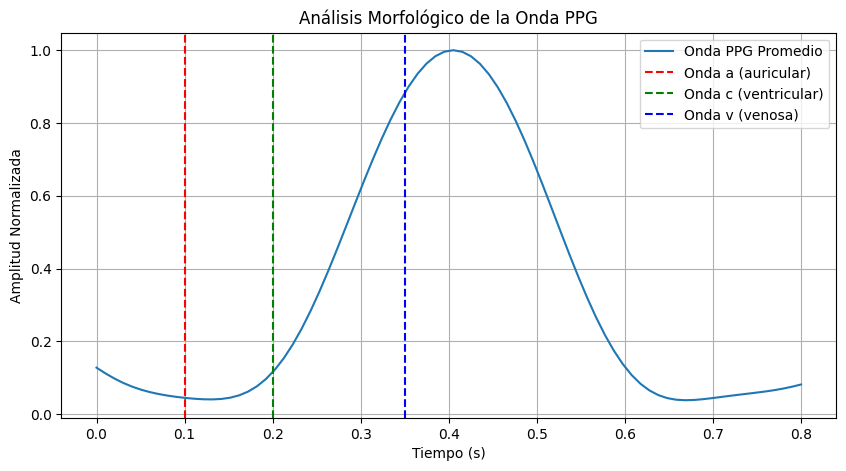

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

df["ppg_ir"] = df["ppg_ir"].values
fs = 100
df["time"] = np.arange(len(df)) / fs
ppg=df["ppg_ir"]

#Filtrado pasa banda
def bandpass_filter(signal, fs, low=0.5, high=5, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, signal)

ppg_filtered = bandpass_filter(ppg, fs)

#Detección de picos (latidos)
peaks, _ = find_peaks(ppg_filtered, distance=int(0.6*fs))

#Segmentación de ciclos cardíacos (PPG de cada latido)
cycles = []
window = int(0.8 * fs)  # Duración de cada ciclo (~800 ms)

for peak in peaks:
    if peak - window//2 > 0 and peak + window//2 < len(ppg_filtered):
        segment = ppg_filtered[peak - window//2 : peak + window//2]
        cycles.append(segment)

# Normalizacion de los Ciclos para posterior analisis con Clustering
cycles = np.array(cycles)
cycles_norm = (cycles - cycles.min(axis=1)[:, None]) / (cycles.max(axis=1) - cycles.min(axis=1))[:, None]
mean_cycle = np.mean(cycles_norm, axis=0)

# Comparacion del ciclo promedio para obtener la señal PVY
t_cycle = np.linspace(0, len(mean_cycle)/fs, len(mean_cycle))

plt.figure(figsize=(10, 5))
plt.plot(t_cycle, mean_cycle, label='Onda PPG Promedio')
plt.title('Análisis Morfológico de la Onda PPG')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud Normalizada')
plt.grid(True)
plt.legend()

plt.axvline(x=0.1, color='r', linestyle='--', label='Onda a (auricular)')
plt.axvline(x=0.2, color='g', linestyle='--', label='Onda c (ventricular)')
plt.axvline(x=0.35, color='b', linestyle='--', label='Onda v (venosa)')
plt.legend()
plt.show()

## Caracterizacion del ciclo promedio para obtener: Amplitud de picos, Duracion de la onda, Inclinacion de subida, Area bajo la curva AUC

In [ ]:
from scipy.signal import find_peaks

# picos dentro del ciclo promedio (onda a, v)
peaks_mean, _ = find_peaks(mean_cycle, distance=int(0.2 * fs))  # distancia mínima entre a y v
valleys_mean, _ = find_peaks(-mean_cycle, distance=int(0.2 * fs))  # valles negativos

# Asegurarse que haya al menos 2 picos y 1 valle
if len(peaks_mean) >= 2 and len(valleys_mean) >= 1:
    idx_a = peaks_mean[0]
    idx_v = peaks_mean[1]
    idx_valle = valleys_mean[np.argmin(np.abs(valleys_mean - (idx_a + idx_v)//2))]

    # caracterizacion de la señal
    duracion_a_v = (idx_v - idx_a) / fs  # tiempo entre a y v
    amplitud_a = mean_cycle[idx_a] - mean_cycle[idx_valle]
    amplitud_v = mean_cycle[idx_v] - mean_cycle[idx_valle]
    inclinacion_a = (mean_cycle[idx_a] - mean_cycle[idx_valle]) / ((idx_a - idx_valle) / fs)
    inclinacion_v = (mean_cycle[idx_v] - mean_cycle[idx_valle]) / ((idx_v - idx_valle) / fs)
    auc_total = np.trapz(mean_cycle, dx=1/fs)  # área bajo la curva total

    print(" Características del ciclo PPG promedio:")
    print(f" Duración a-v: {duracion_a_v:.3f} s")
    print(f" Amplitud onda a: {amplitud_a:.3f}")
    print(f" Amplitud onda v: {amplitud_v:.3f}")
    print(f" Inclinación subida a: {inclinacion_a:.3f}")
    print(f" Inclinación subida v: {inclinacion_v:.3f}")
    print(f" Área total bajo la curva (AUC): {auc_total:.3f}")

    plt.figure(figsize=(10, 5))
    plt.plot(t_cycle, mean_cycle, label='Ciclo Promedio')
    plt.plot(t_cycle[idx_a], mean_cycle[idx_a], 'go', label='Pico a')
    plt.plot(t_cycle[idx_v], mean_cycle[idx_v], 'bo', label='Pico v')
    plt.plot(t_cycle[idx_valle], mean_cycle[idx_valle], 'ro', label='Valle base')
    plt.title('Identificación de Ondas y Características')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud Normalizada')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Error: No se detectaron suficientes picos para estimar características...")


Error: No se detectaron suficientes picos para estimar características...


## Analisis de Anomalias de los cliclos promedios mediante K-means Clustering y PCA(analisis de componentes principales)

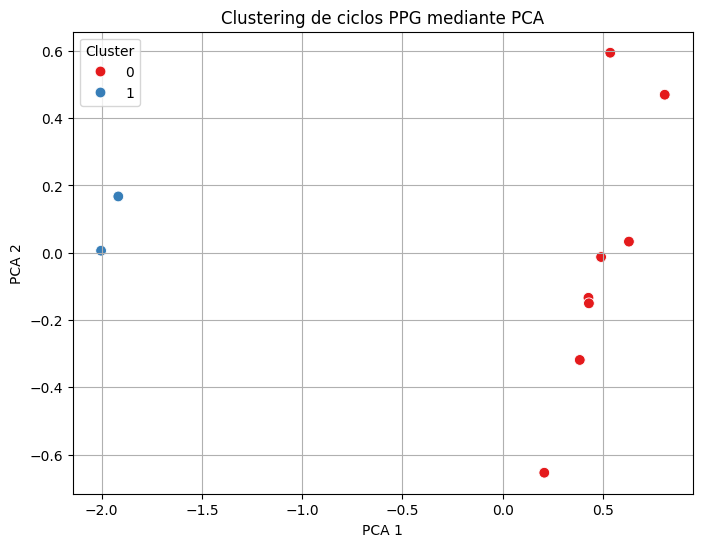

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

# Normalizado de los ciclos a la misma longitud
from scipy.interpolate import interp1d

N = 100  # puntos por ciclo
normalized_cycles = []

for c in cycles:
    x_old = np.linspace(0, 1, len(c))
    x_new = np.linspace(0, 1, N)
    interp = interp1d(x_old, c, kind='linear')
    normalized_cycle = interp(x_new)
    normalized_cycles.append(normalized_cycle)

normalized_cycles = np.array(normalized_cycles)

# PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(normalized_cycles)

#KMeans clustering (3 clusteres o grupo de latidos para analizar anomalias)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='Set1', s=60)
plt.title("Clustering de ciclos PPG mediante PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


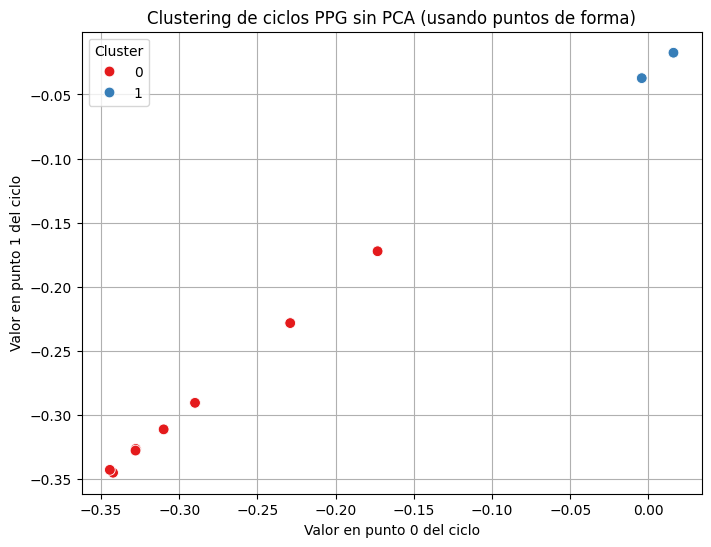

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Suponiendo que ya tienes tu lista de ciclos PPG en la variable `cycles`
N = 100  # número de puntos por ciclo
normalized_cycles = []

for c in cycles:
    x_old = np.linspace(0, 1, len(c))
    x_new = np.linspace(0, 1, N)
    interp = interp1d(x_old, c, kind='linear')
    normalized_cycle = interp(x_new)
    normalized_cycles.append(normalized_cycle)

normalized_cycles = np.array(normalized_cycles)

# Clustering directamente sobre los ciclos (sin PCA)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(normalized_cycles)

# Visualización de los clusters: ejemplo con los primeros 2 puntos del ciclo como eje X/Y (solo para graficar algo)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=normalized_cycles[:, 0], y=normalized_cycles[:, 1], hue=labels, palette='Set1', s=60)
plt.title("Clustering de ciclos PPG sin PCA (usando puntos de forma)")
plt.xlabel("Valor en punto 0 del ciclo")
plt.ylabel("Valor en punto 1 del ciclo")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


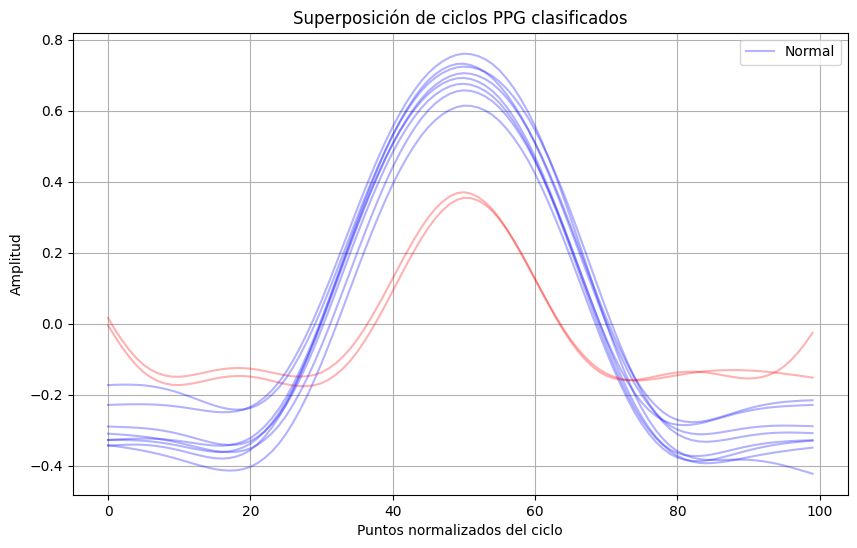

In [ ]:
plt.figure(figsize=(10, 6))

for i in range(len(normalized_cycles)):
    if labels[i] == 0:
        plt.plot(normalized_cycles[i], color='blue', alpha=0.3, label='Normal' if i == 0 else "")
    else:
        plt.plot(normalized_cycles[i], color='red', alpha=0.3, label='Anómalo' if i == 1 else "")

plt.title("Superposición de ciclos PPG clasificados")
plt.xlabel("Puntos normalizados del ciclo")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.show()
